# Optimization Methods

## 1. How We Structure Optimization
Optimization methods by in large have two main structures. The first, line search, is simple enough. Pick a direction, pick a size, and take a step within that size. Within this method, there are three techniques I've studied: Steepest descent, Newton descent, and BFGS method. The other approach to optimization is the trust region method. Here, you designate a region of trust and minimize the subproblem. If the subproblem minimzation would result in unfavorable results (uphill or insufficiently downhill), you shrink the trust region and try again. On the other hand, if the minimization is sufficient improvement, you  take the step and increase the region. 

Optimization problems have ideal problems, and each deviation from them leads to increasingly difficult problems. It is worth laying out these ideal problems and working with them, as they are important to consider when working with non-ideal problems. 
An ideal problem is convex, continuous, unconstrained, deterministic, small, and about local optimization. Flipping these, the hardest problems are non-convex, discrete, constrained, stochastic, very large, or about global optimization.  

With both approaches and obstacles outlined, we will start with the three line search techniques mentioned.

## 2. Line Search
The basic structure of line search methods is given below: 

In [5]:
# Given function g and starting point x0,
# calculate gradient g'
# xk = x0
# while |g'| \neq 0
#    pk =  get step direction at xk
#    a = step size at xk
#    xk+1 = xk + a*pk
#return xk

With this, we must consider both step direction and step size. For step direction, we begin with the easiest method we know of.
### 2.1 Steepest Descent
The steepest descent method is the workhorse of the optimization method. Its idea is to find the direction of steepest descent by examining the gradient at the current point and then stepping that direction. Because it only requires the gradient, it is a simple technique usable for most problems. Furthermore, this allows it to easily work on discrete problems. This is why steepest descent is a starting point for many data science, machine learning, and image processing problems. 

With the simplicity of the problem, it is the perfect place to introduce the main two methods we have for stepsize. They are based on the wolfe conditions, known separately as the armijo curvature conditions. The armijo condition can be satisfied using a simple backtracking method, seen below (along with some package imports for later down the line):

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
def backtrack(pk, rho):
    alph = 1
    while (g(x0+alph*pk) > g(x0) + c1*alph*pk.dot(gr)): #backtracking Algo
        alph *= rho
    return alph

While this is simple, it is not particularly effective. However, if we want to implement the second wolfe condition, we must complexify our algorithm quite a bit. Below is the result of that:

In [41]:
def strongWolfe(alph1):     #COMMENTATE THIS FUNCTION BRO
    alph = 0
    alphmax = 5.
    phi_a0 = g(x0+alph*pk)
    i = 1
    
    while(True):
        phi_a1 = g(x0+alph1*pk)
        
        #IS ARMIJO CONDITION NOT SATISFIED????
        if ((phi_a1 > phi_0 + c1*alph1*phiP_0) or (phi_a1 >= phi_a0 and i > 1)): 
            alphfinal = zoom(alph,alph1, phi_a0,phi_a1)
            return alphfinal
        #IF IT IS, IS CURVATURE CONDITION SATISFIED?
        phiP_a1 = gradg(x0+alph1*pk).dot(pk)
        if(abs(phiP_a1) <= -c2*phiP_0):    
            alphfinal = alph1
            return alphfinal
        
        #IS OUR STEP TAKING US UPHILL?
        if (phiP_a1 >= 0):
            alphfinal = zoom(alph1,alph,phi_a1,phi_a0)
            return alphfinal

        #GO TO NEXT STEP
        alph = alph1
        phi_a0 = phi_a1
        alph1 = 1.5*alph1         #If alphmax < than step that satisfies these, does this break?
        alph1 = min(alph1,alphmax)  
        i +=1
        
def zoom(alow,ahigh, phi_alow, phi_ahigh):
    if phi_alow > phi_ahigh:
        temp = ahigh
        ahigh = alow
        alow = temp
    
    
    while(True):
        aj = interpolateHermite(alow,ahigh,phi_alow,phi_ahigh)

        #COMPUTE PHI AT INTERPOLATED VALUE AND AT LOWEST VALUE
        phi_aj = g(x0+aj*pk)
        
        #CHECK TO SEE IF WE DONT SATISFY ARMIJO. IF NOT, KEEP GOING
        if((phi_aj > phi_0 + c1*aj*phiP_0) or (phi_aj >= phi_alow)): #Armijo
            ahigh = aj
            phi_ahigh = phi_aj
        else:
            #IF WE DO, CALC PHI' AND CHECK CURVATURE. IF SATISFIED, RETURN STEP
            phiP_aj = gradg(x0+aj*pk).dot(pk)
            if(abs(phiP_aj) <= -c2*phiP_0):     
                afinal = aj
                return afinal
            if (phiP_aj*(ahigh - alow) >= 0):   #Uunderstand this step?!!
                ahigh = alow
                phi_ahigh = phi_alow
            alow = aj
            phi_alow = phi_aj
            
def interpolateHermite(alow, ahigh, phi_alow,phi_ahigh):
    #RECALCULATE PHI OF THESE 
                                    ##CONSIDER TAKING VALUES FROM EARLIER
    phi_alow = g(x0+alow*pk)
    phiP_alow =  gradg(x0+alow*pk).dot(pk)
    
    phiP_ahigh = gradg(x0+ahigh*pk).dot(pk)
    
    #CONSTRUCT MINIMUM FROM H'(A) = 0
    
    d1 = phiP_alow + phiP_ahigh-3.*(phi_alow-phi_ahigh)/(alow-ahigh)
    sgn = (ahigh - alow >= 0) - 1*(ahigh - alow < 0)
    d2 = sgn*np.sqrt(d1**2-phiP_alow*phiP_ahigh)
    
    amid = ahigh - (ahigh - alow)*(phiP_ahigh + d2-d1)/(phiP_ahigh - phiP_alow + 2*d2)
    return amid



The second method seems like a lot of added complexity. Thus, it better be worth the work! Luckily, we will see later that it greatly increases performance on all of our methods. Before that, however, we should introduce steepest descent. Steepest descent is simply about going the negative gradient direction. Thus, it is simply this:

In [42]:
def steepest(gradg):
    return -gradg

With our simple yet efficient method for step direction and our two methods for step size, we can dive straight into our first linesearch method. The full algorithm is below. You can see that we attempt to minimize the 2-D rosenbrock function (or banana function!), a classic case. 

In [43]:
def g(x):
        return 100.*(x[1]-x[0]**2)**2 + (1.-x[0])**2
def gradg(x):
    return np.array([ -400*x[0]*x[1] + 400*x[0]**3 - 2 + 2*x[0], 200*x[1]- 200*x[0]**2])

In [44]:
xstart = np.array([-1.2,1.])
x0 = xstart

counter = 0 #Iteration count
rho = .5    #values for backgracking algorithm
c1 = 10**-4
    
xgraph = []
ygraph = []
while (np.linalg.norm(gradg(x0)) > 10**-8):
    counter+=1  #increase iteration count
    gr = gradg(x0)      #calc gradient and hessian
    pk = steepest(gr) #calc step direction
    alph = backtrack(pk,.5)
    xnew = x0 + alph*pk #take step
    x0 = xnew
    #Append information for graphs
    xgraph.append(x0[0])
    ygraph.append(x0[1])
print(counter)

print(f'x* = {x0}')

print(f'f(x*) = {g(x0)}')

print(f'gradf(x*) = {gradg(x0)}')

19435
x* = [0.99999999 0.99999998]
f(x*) = 6.106583285154426e-17
gradf(x*) = [-9.51783230e-09 -3.05405479e-09]


We see that it converges in 19435 iterations, which is slow. Graphing it, we see the path taken by our algorithm. 

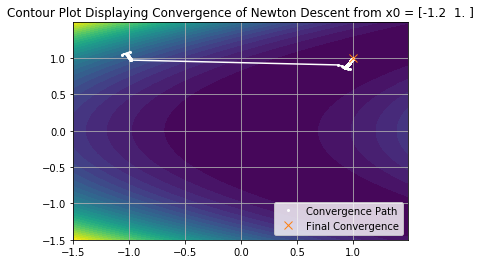

In [45]:
#Graph Contour plot

fig, ax = plt.subplots()

xplot = np.arange(-1.5,1.5,.01)
yplot = np.arange(-1.5,1.5,.01)

zplot = np.ones((xplot.size,yplot.size))
for i in range(0,xplot.size):
    for j in range(0,yplot.size):
        xyplot = [xplot[i],yplot[j]]
        zplot[i,j] = g(xyplot)

Contours = np.linspace(zplot.min(),zplot.max(),30)
plt.contourf(xplot, yplot, zplot,Contours)

plt.plot(xgraph,ygraph, 'w')
plt.plot(xgraph,ygraph,'wo', markersize = 2, label = "Convergence Path")
plt.plot(x0[0],x0[1],'C1x',markersize = 8, label = "Final Convergence")
ax.set_title(f'Contour Plot Displaying Convergence of Newton Descent from x0 = {xstart}')
ax.legend(loc = 4)
ax.grid()
plt.show()

Clearly, most of those steps are very small! Implementing both Wolfe conditions instead of just the armijo condition, however leads to better results. The code changes slightly but is presented below. 

In [48]:
x0 = xstart

counter = 0 #Iteration count
alph1 = 1
c1 = 10**-4
c2 = .1
xgraph = []
ygraph = []
while (np.linalg.norm(gradg(x0)) > 10**-8):
    counter+=1  #increase iteration count
    gr = gradg(x0)      #calc gradient and hessian
    pk = steepest(gr) #calc step direction
    phi_0 = g(x0)
    phiP_0 = gradg(x0).dot(pk)
    alph = strongWolfe(alph1)
    alph1 = min(1,1.1*alph)
    xnew = x0 + alph*pk #take step
    x0 = xnew
    #Append information for graphs
    xgraph.append(x0[0])
    ygraph.append(x0[1])
print(counter)

print(f'x* = {x0}')

print(f'f(x*) = {g(x0)}')

print(f'gradf(x*) = {gradg(x0)}')

#Graph Contour plot

2269
x* = [0.99999999 0.99999998]
f(x*) = 1.1821358788228815e-16
gradf(x*) = [-2.94192648e-09 -9.39147071e-09]


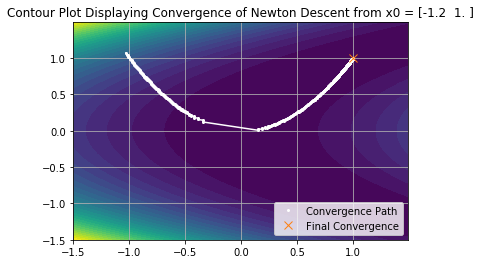

In [49]:
#Graph Contour plot

fig, ax = plt.subplots()

xplot = np.arange(-1.5,1.5,.01)
yplot = np.arange(-1.5,1.5,.01)

zplot = np.ones((xplot.size,yplot.size))
for i in range(0,xplot.size):
    for j in range(0,yplot.size):
        xyplot = [xplot[i],yplot[j]]
        zplot[i,j] = g(xyplot)

Contours = np.linspace(zplot.min(),zplot.max(),30)
plt.contourf(xplot, yplot, zplot,Contours)

plt.plot(xgraph,ygraph, 'w')
plt.plot(xgraph,ygraph,'wo', markersize = 2, label = "Convergence Path")
plt.plot(x0[0],x0[1],'C1x',markersize = 8, label = "Final Convergence")
ax.set_title(f'Contour Plot Displaying Convergence of Newton Descent from x0 = {xstart}')
ax.legend(loc = 4)
ax.grid()
plt.show()

### 2.2 Newton Descent 
